In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
mnist = pd.read_csv('data/mnist_train.csv')
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
mnist.groupby('label')['1x1'].count()

label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: 1x1, dtype: int64

In [5]:
np.random.seed(1)
n_sam = 50
mnist50 = pd.DataFrame(columns=mnist.columns, dtype='int64')
for i in range(10):
    samples = mnist[mnist.label==i].sample(n_sam, replace=False)
    mnist50 = pd.concat([mnist50, samples], ignore_index=True)
mnist50.label.value_counts()

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
Name: label, dtype: int64

In [6]:
mnist50.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
mnist50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 3.0 MB


In [8]:
X = mnist50.drop(['label'], axis=1)
y = mnist50.label

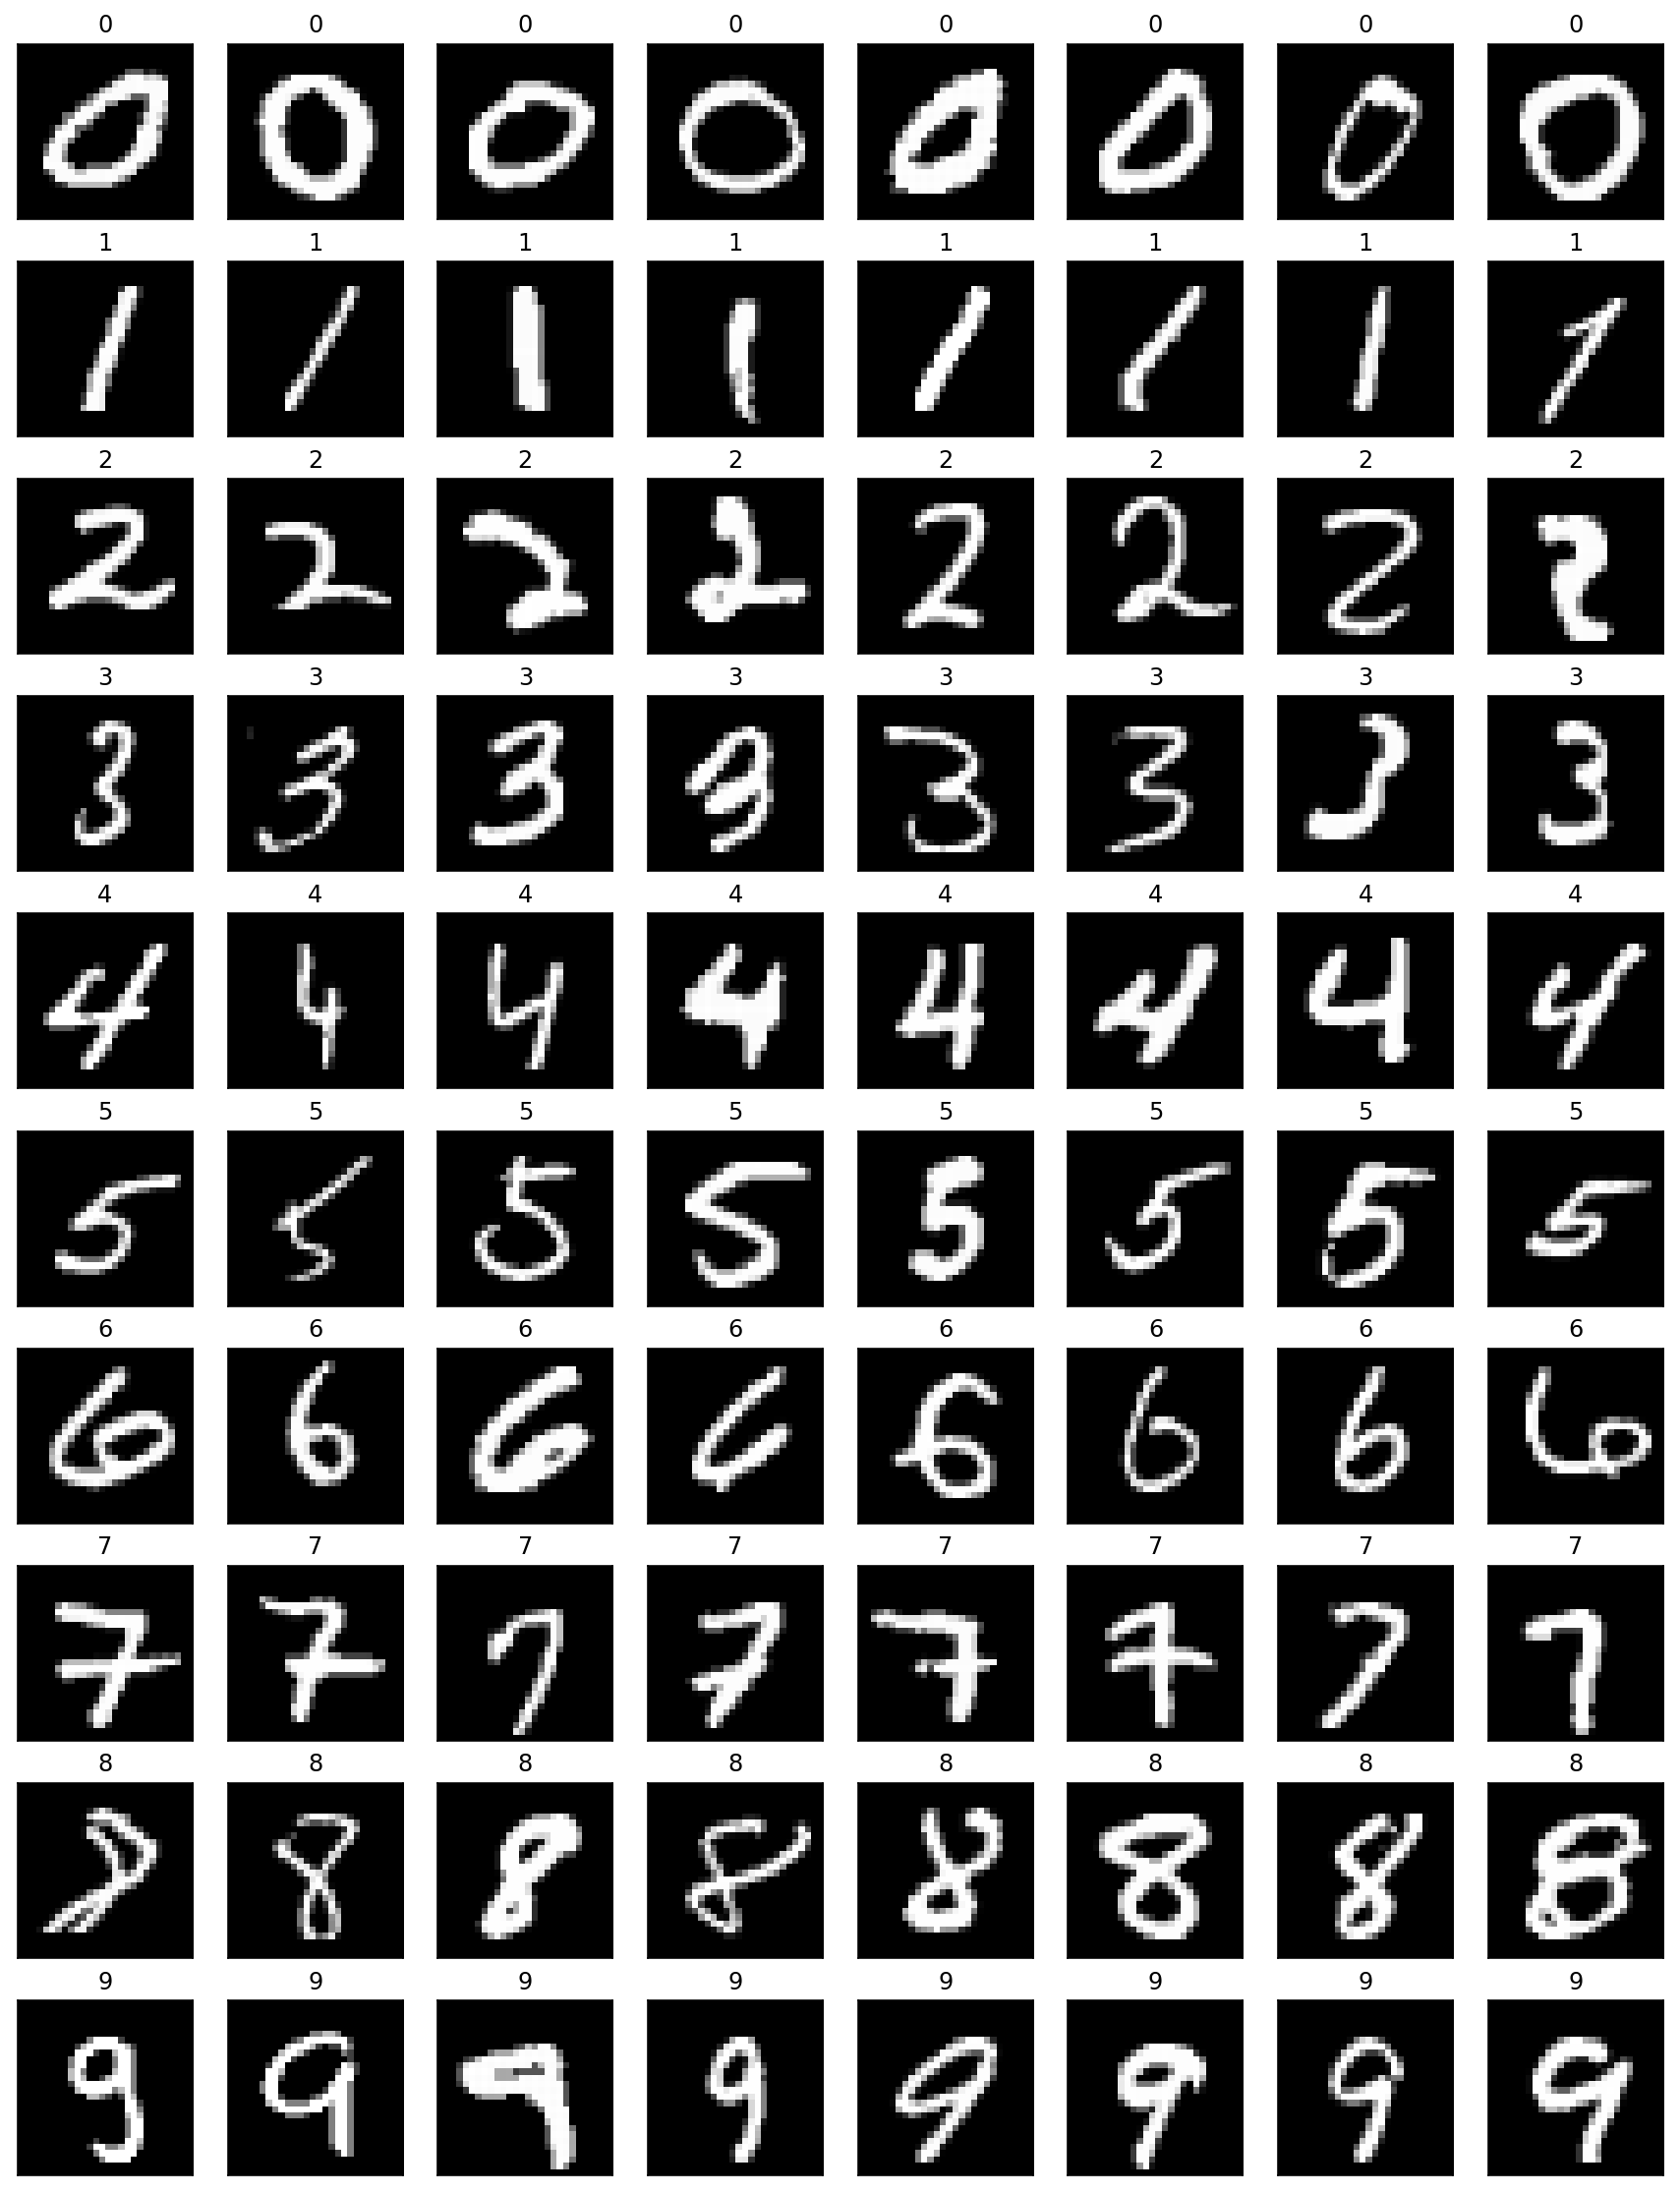

In [14]:
np.random.seed(0)
n_sam = 8
samples = {i:y[y==i].sample(n_sam, replace=False).index for i in range(10)}
plt.figure(figsize=(15,20))
for i in range(10*n_sam):
    dig, sam = i//n_sam, i%n_sam
    plt.subplot(10,n_sam,i+1)
    img = X.iloc[samples[dig][sam]].values.reshape((28,28))
    plot_mnist(img, y[samples[dig][sam]])

In [11]:
features = mnist50.drop('label', axis=1)
label = mnist50.label

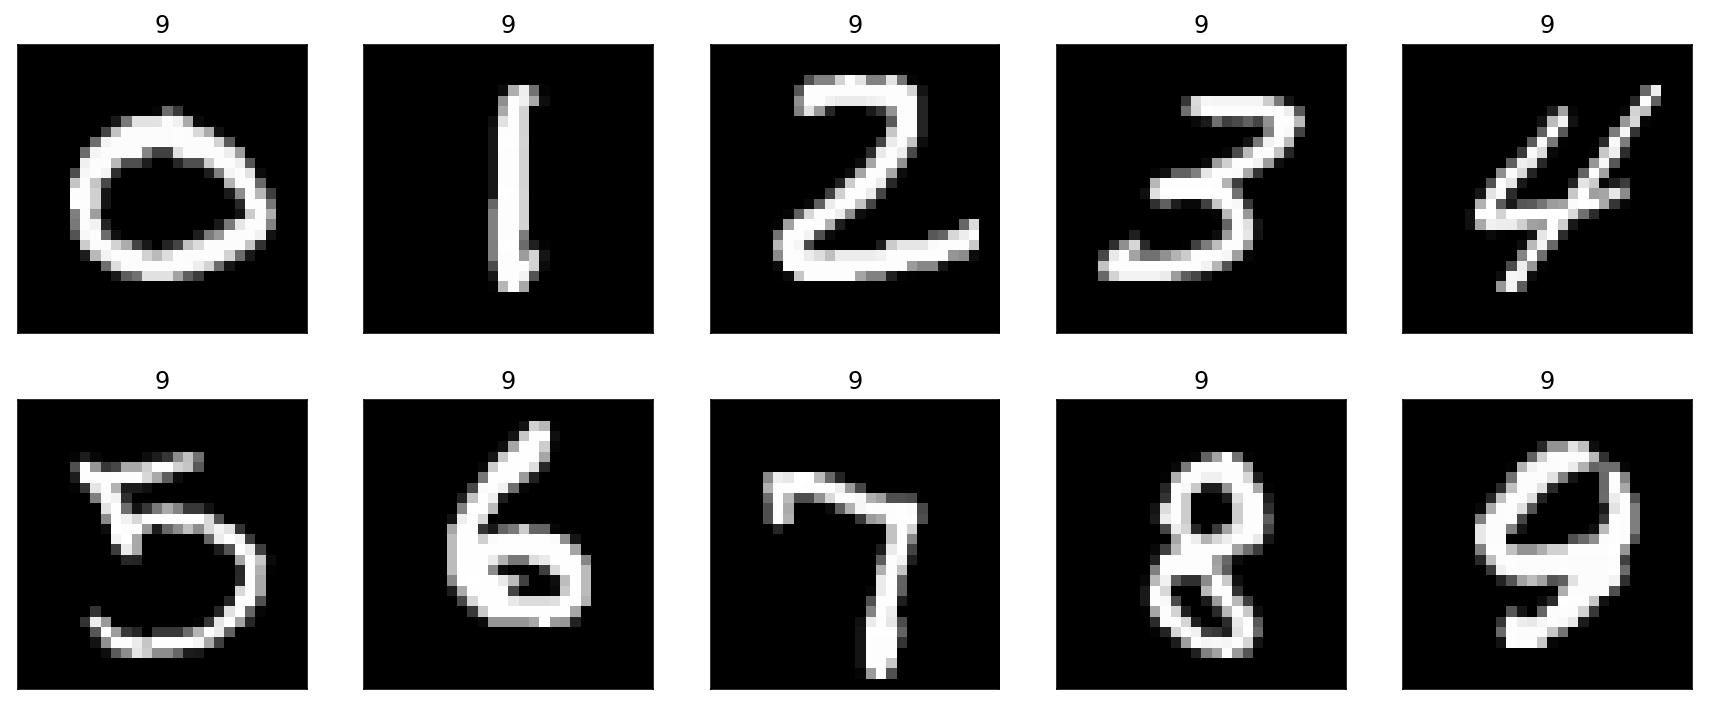

In [15]:
np.random.seed(32)
r, c = 2, 5
samp_ind = [label[label==i].sample(1, replace=False).index[0] for i in range(10)]
plt.figure(figsize=(15,6))
for i in range(r*c):
    plt.subplot(r,c,i+1)
    img = features.iloc[samp_ind[i]].values.reshape((28,28))
    plot_mnist(img, y[samples[dig][sam]])

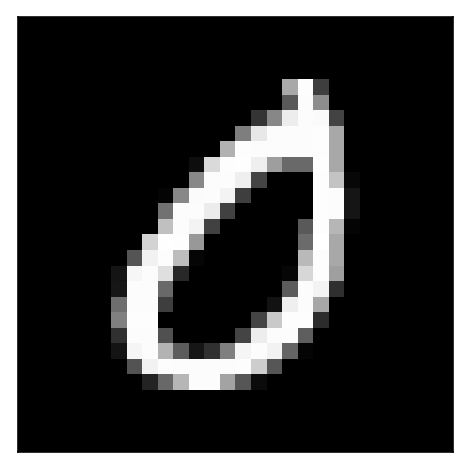

In [16]:
ind = 0
img = features.iloc[ind].values
plot_mnist(img)

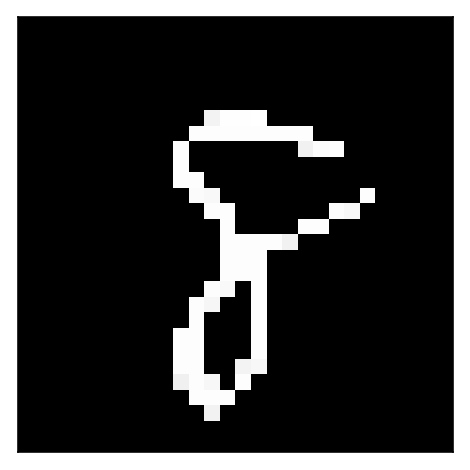

In [17]:
ind = 410
img = np.array(features.iloc[ind].values)
img[img<240]=0
plot_mnist(img)

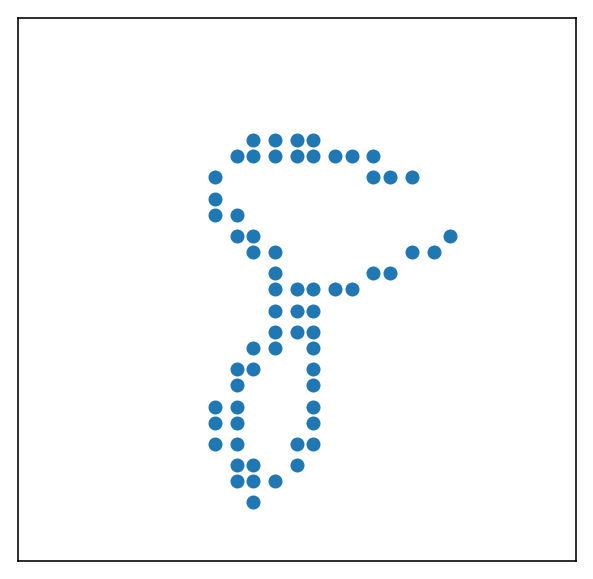

In [18]:
r, c = np.where(img.reshape((28,28))>240)
x_coor, y_coor = (c*100/28).astype('int64'), ((28-r)*100/28).astype('int64')
plt.figure(figsize=(5,5))
plot_coord(np.concatenate((x_coor.reshape(-1,1), y_coor.reshape(-1,1)), axis=1))

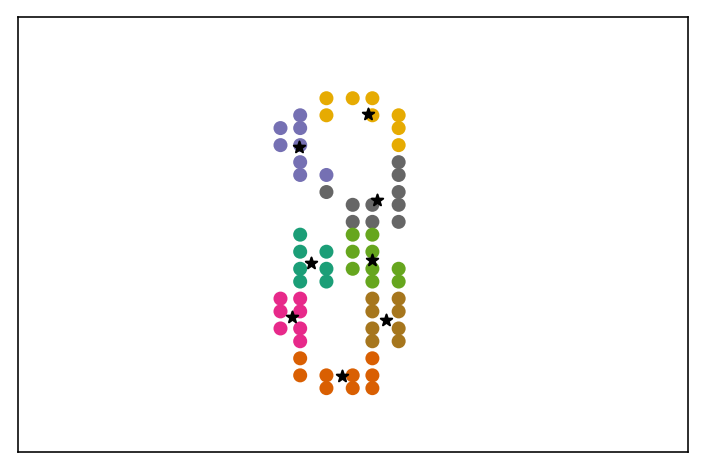

In [19]:
ind=449
km, xy = mnist2clusters(features.iloc[ind].values)
plot_clusters(km, xy)

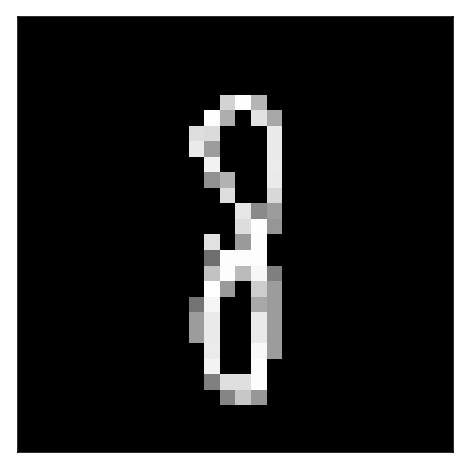

In [20]:
img = np.array(features.iloc[ind].values)
img[img<=100]=0
plot_mnist(img)

In [21]:
np.random.seed(2)
average_mnist = mnist.groupby('label').mean().astype('int64').values
# thld = np.array([70,110,100,110,50,80,100,60,100,70])
# #                0   1   2   3  4  5   6  7   8  9
# with open('centroids.npy', 'rb') as f:
#     centroids = np.load(f)
# # centroids=np.zeros((10,8,2))
# r, c = 2, 5
# plt.figure(figsize=(15,6))
# for i in range(r*c):
#     plt.subplot(r,c,i+1)
#     img= average_mnist[i]
#     img[img<thld[i]] = 0
#     plot_mnist(img)
# plt.show()
# plt.figure(figsize=(15,6))
# for i in range(r*c):
#     plt.subplot(r,c,i+1)
#     img= average_mnist[i]
#     img[img<thld[i]] = 0
#     kmt,xy = mnist2clusters(img, pixval_min=thld[i])
#     plot_clusters(kmt,xy)
# #     centroids[i] = kmt.cluster_centers_
# plt.show()

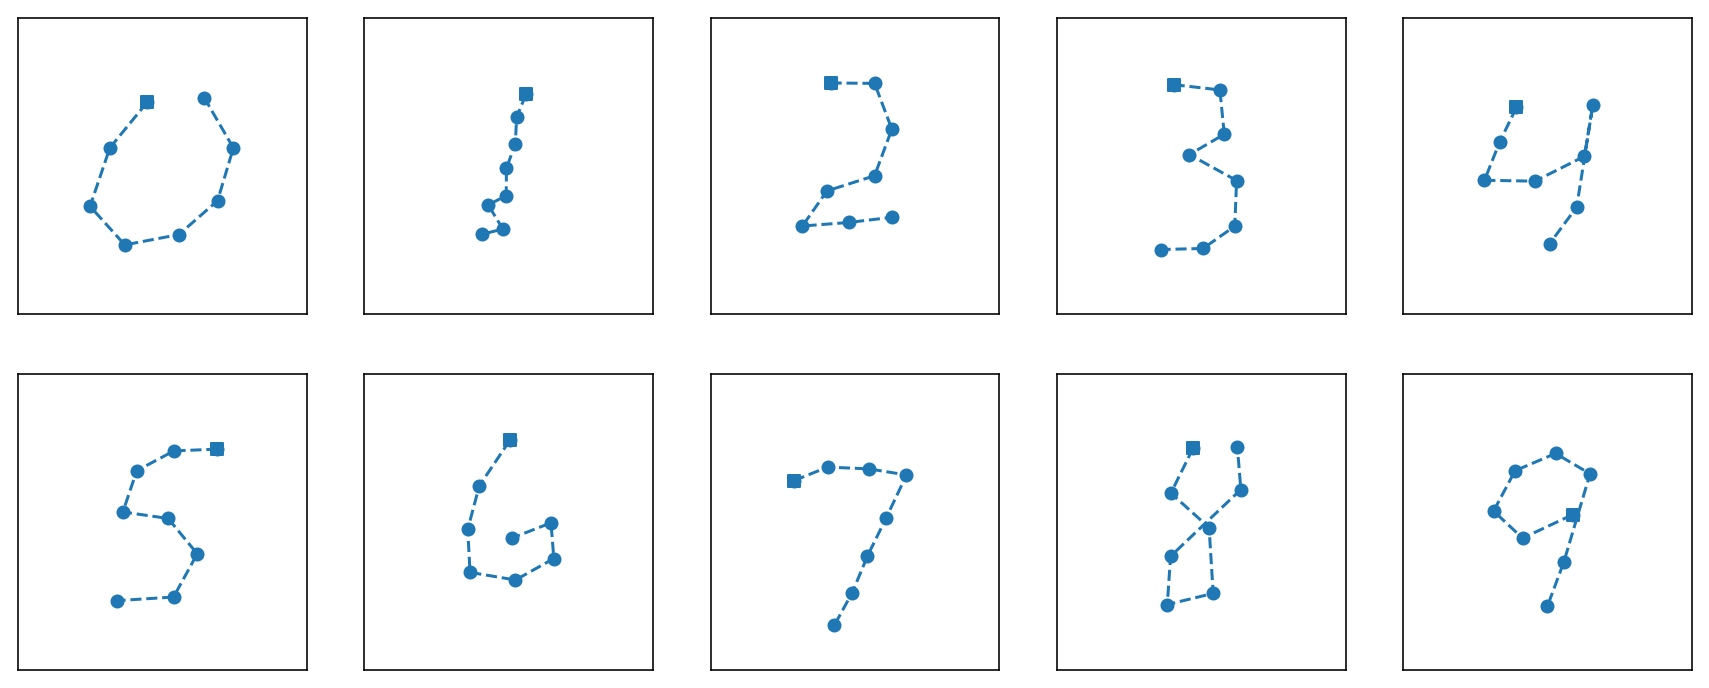

In [24]:
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    tmplt = centroids[i][order[i]]
    plot_exfeatures(tmplt)
plt.show()

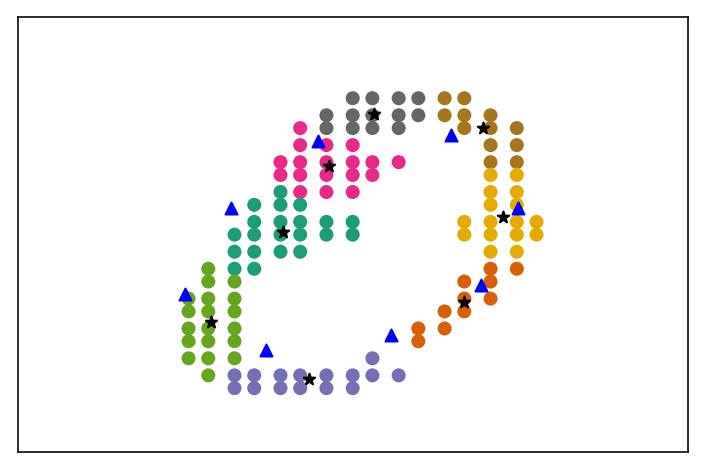

In [25]:
tmplt_0 = centroids[0][order[0]]
img_0 = img2coord(features.iloc[30].values, pixval_min=thld[0])
km0, xy0 = mnist2clusters(features.iloc[30].values, pixval_min=thld[i])
plot_clusters(km0, xy0)
plt.scatter(tmplt_0[:,0], tmplt_0[:,1], marker='^',color='b')

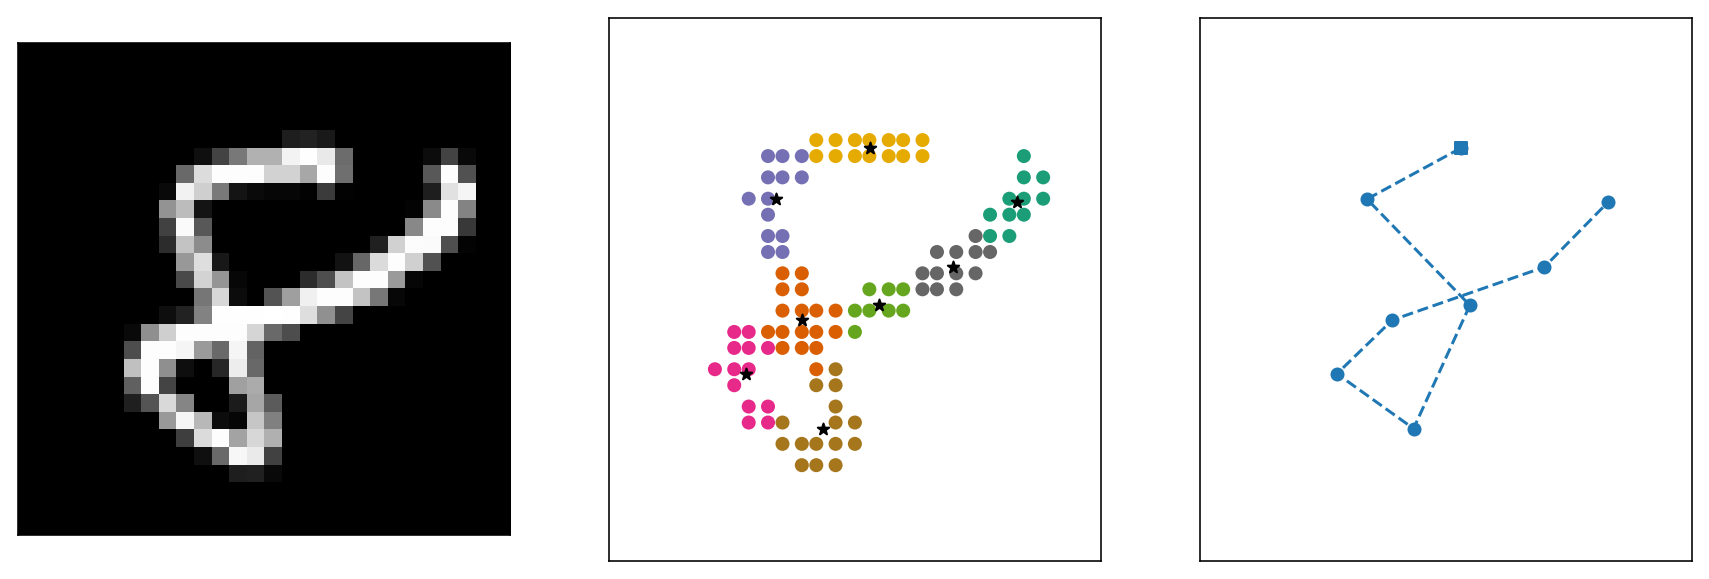

In [29]:
np.random.seed(0)
indx=405
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plot_mnist(features.iloc[indx].values)
pts, kms, xys = feature_extractor(features.iloc[indx].values, label[indx], return_clusters=True)
plt.subplot(1,3,2)
plot_clusters(kms, xys)
plt.subplot(1,3,3)
plot_exfeatures(pts)
plt.show()

In [30]:
allmnist_f = mnist.drop('label', axis=1)
allmnist_l = mnist.label

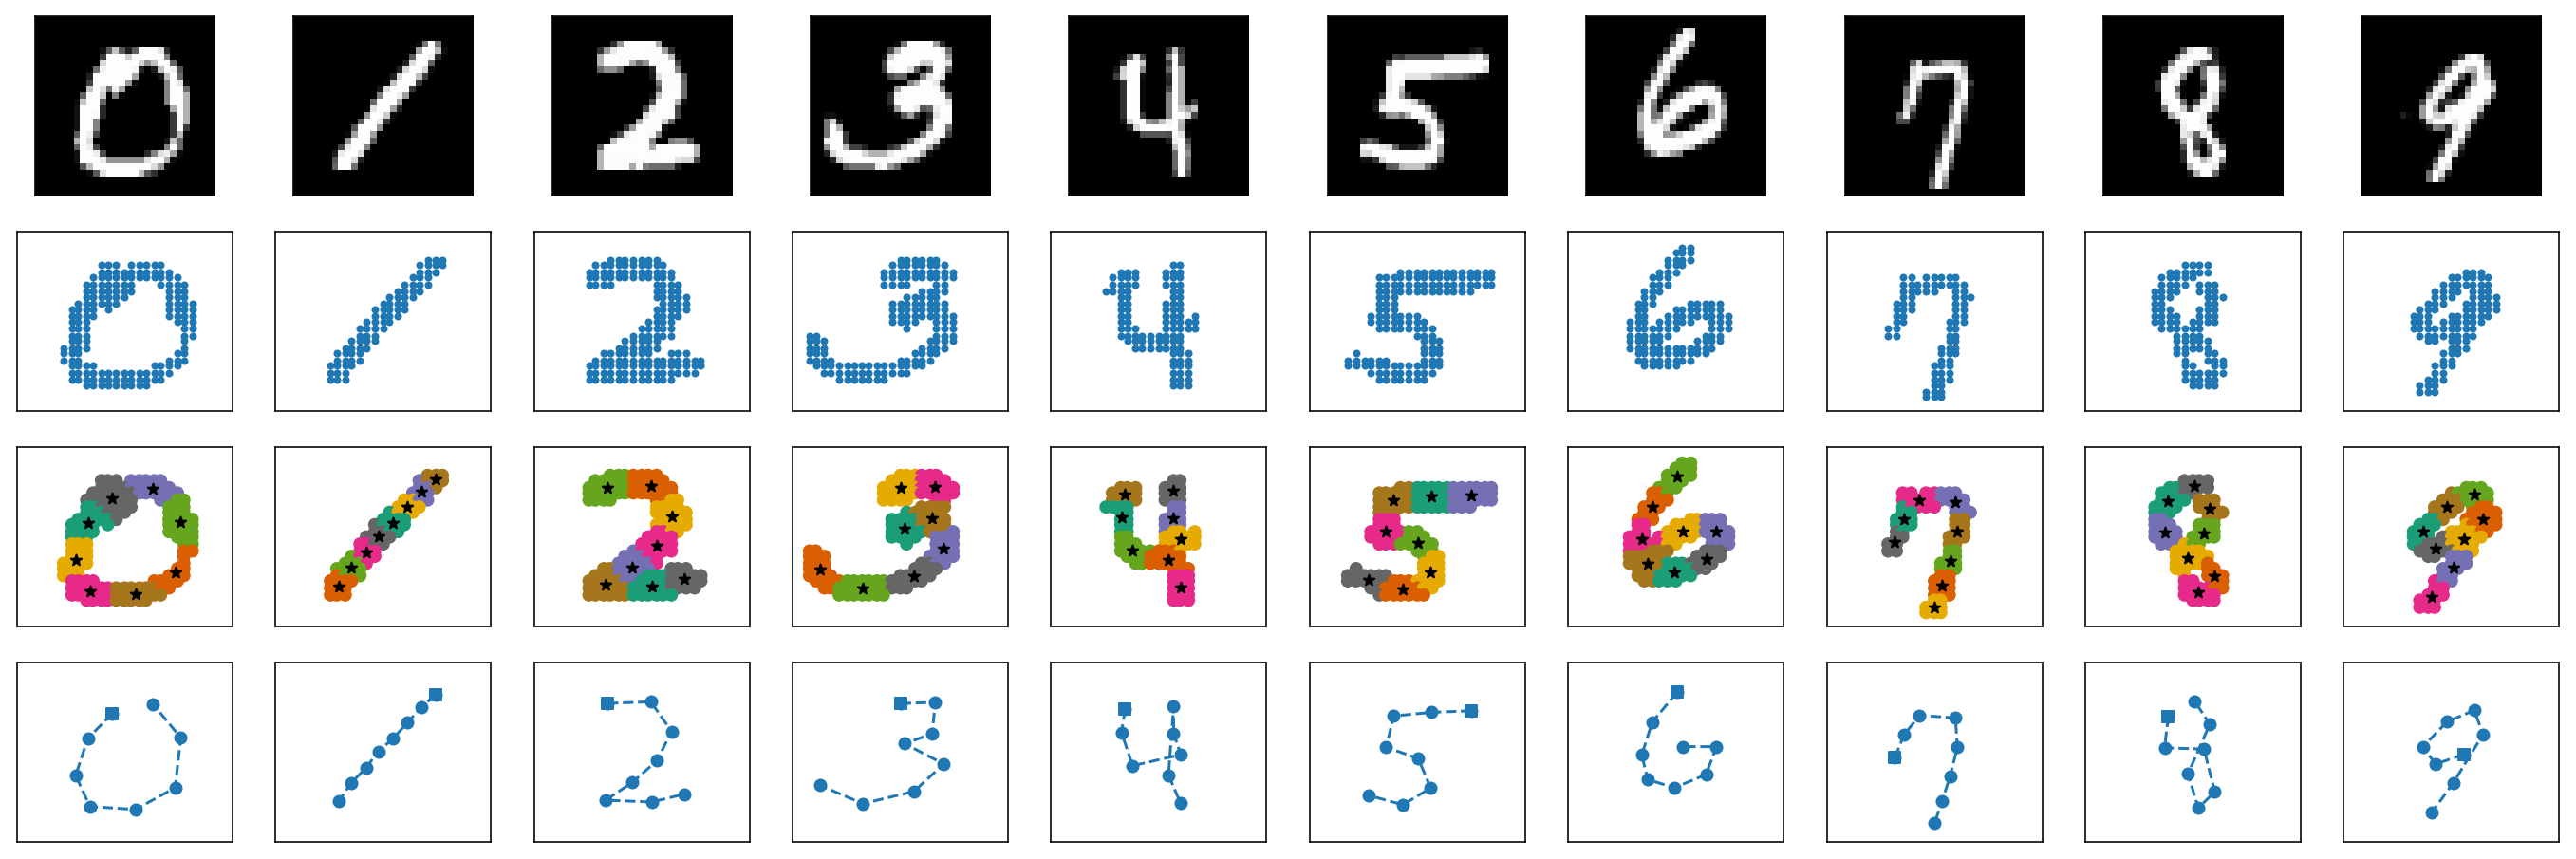

In [31]:
np.random.seed(18)
samples = {i:allmnist_l[allmnist_l==i].sample(1, replace=False).index for i in range(10)}
plt.figure(figsize=(24,8))
for j in range(10):
    indx = samples[j][0]
    plt.subplot2grid((4,10),(0, j))
    plot_mnist(allmnist_f.iloc[indx].values)
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], return_clusters=True)
    plt.subplot2grid((4,10),(1, j))
    plot_coord(xys,'.')
    plt.subplot2grid((4,10),(2, j))
    plot_clusters(kms, xys)
    plt.subplot2grid((4,10),(3, j))
    plot_exfeatures(pts)

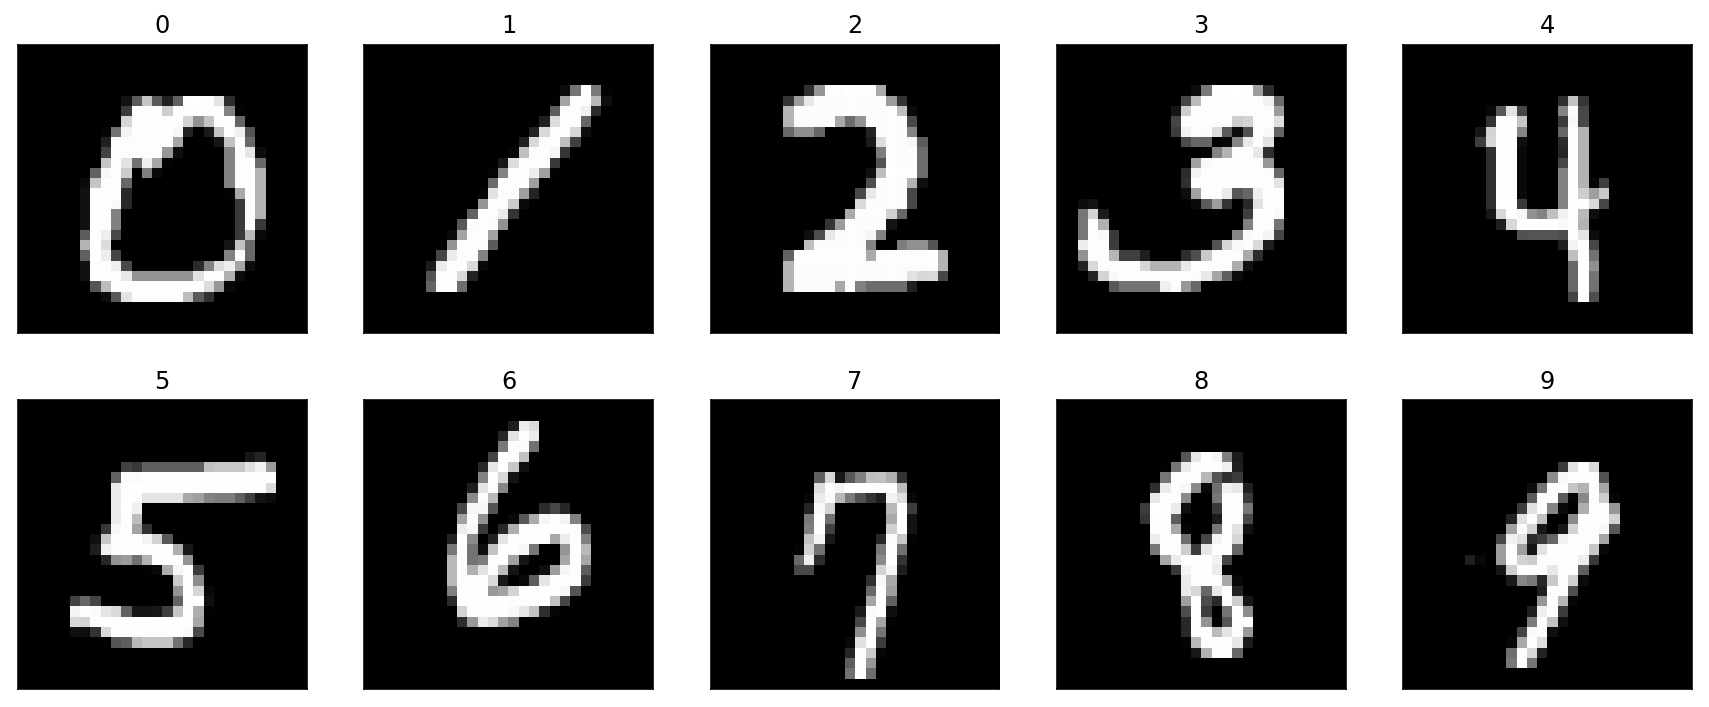

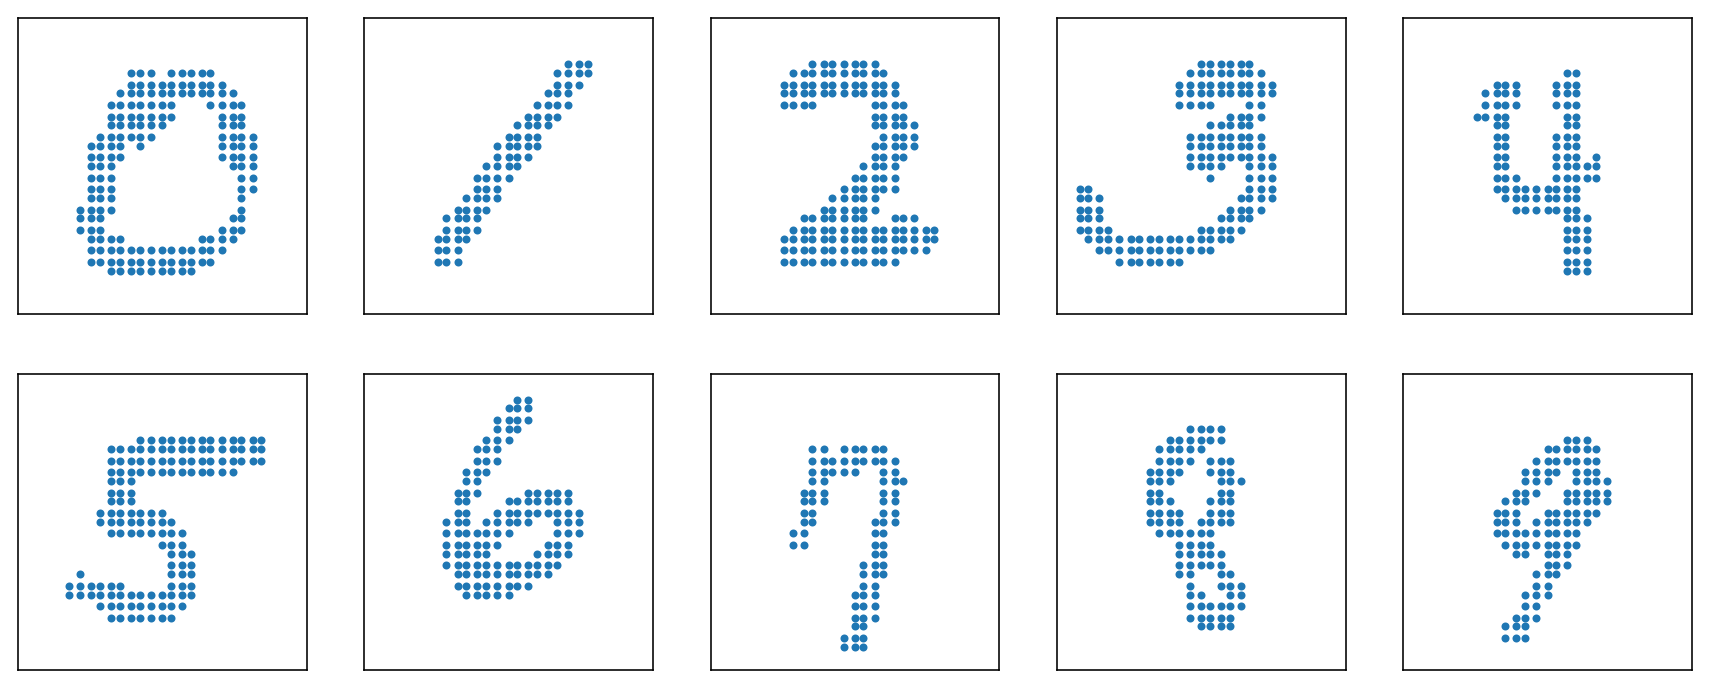

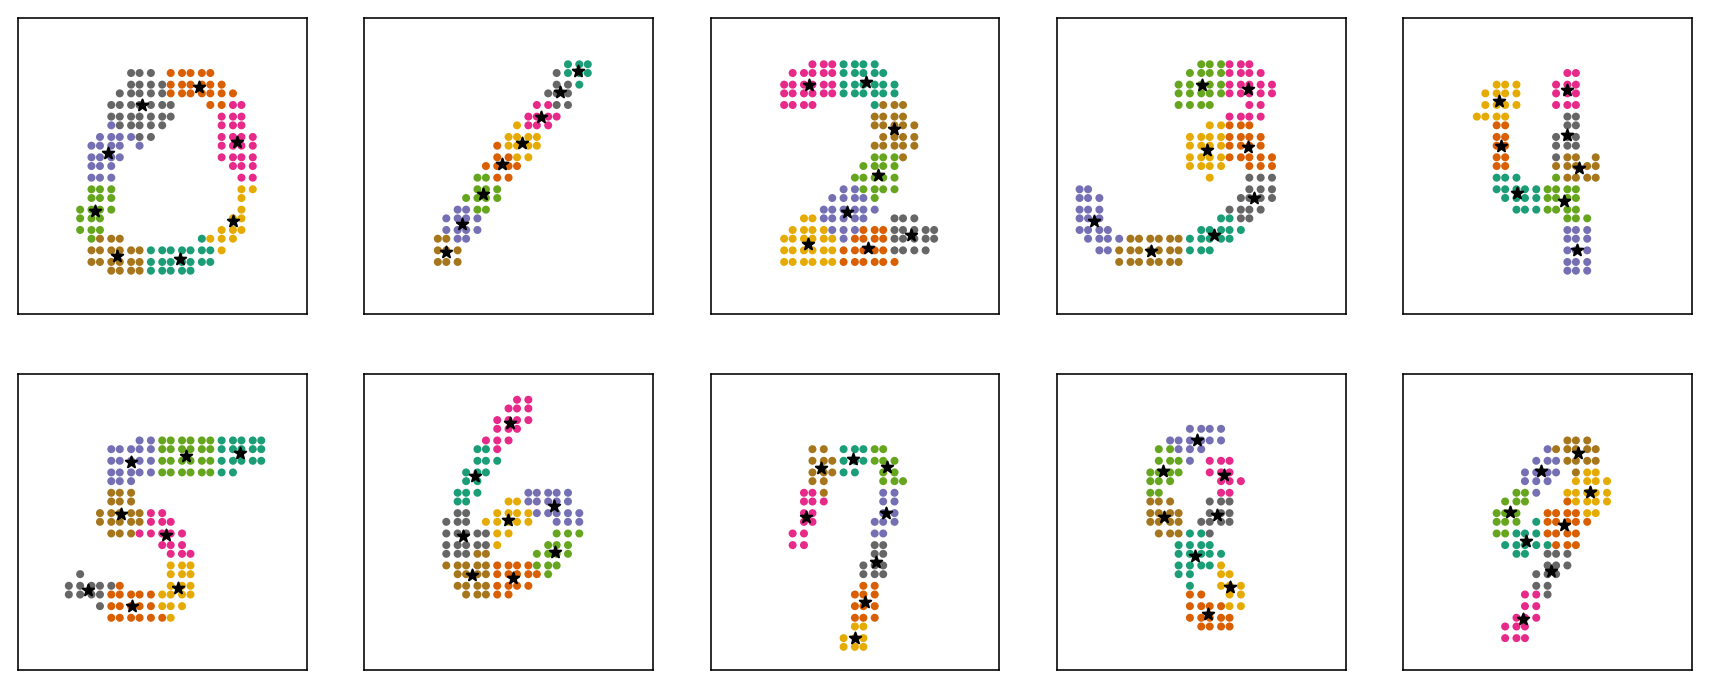

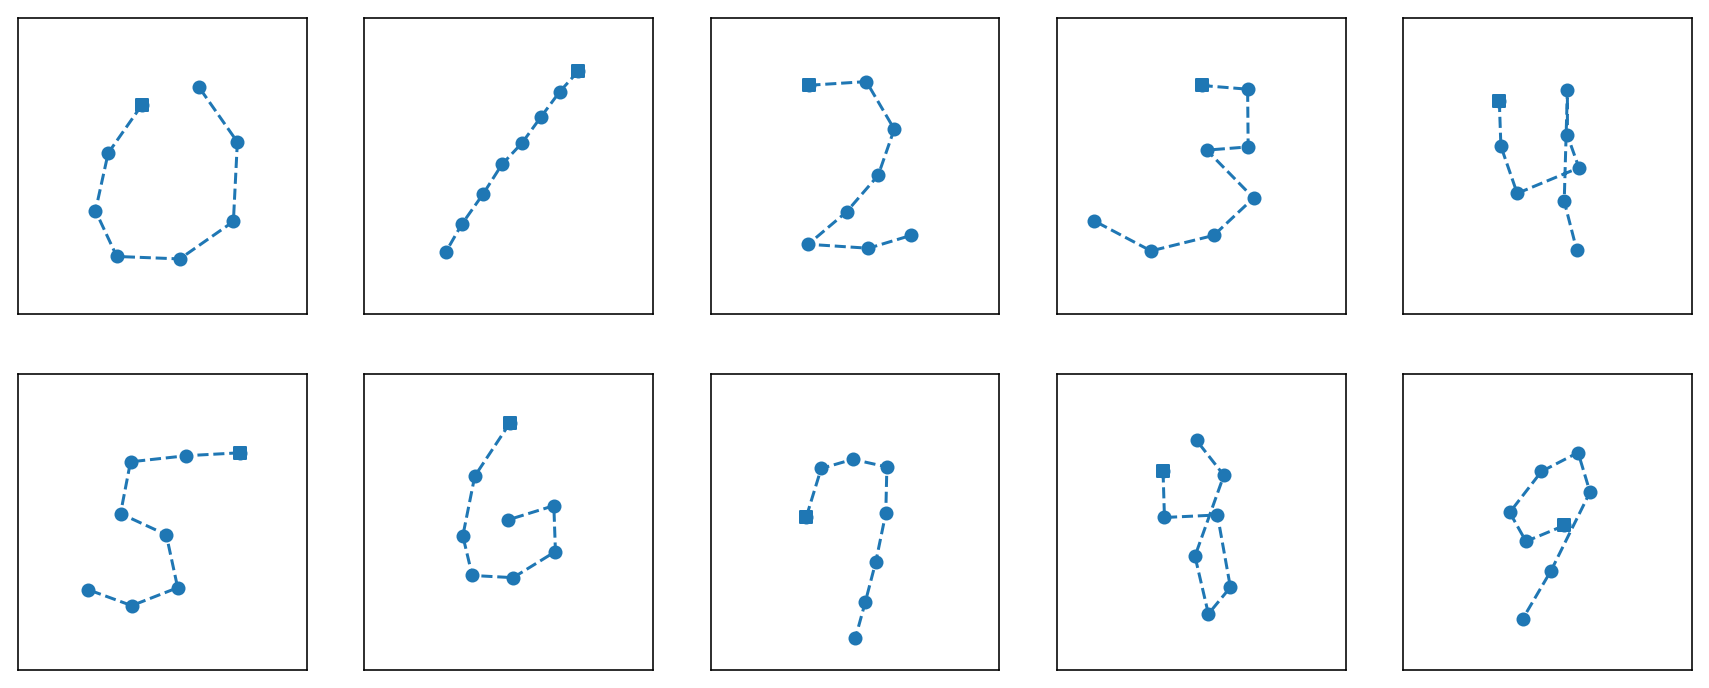

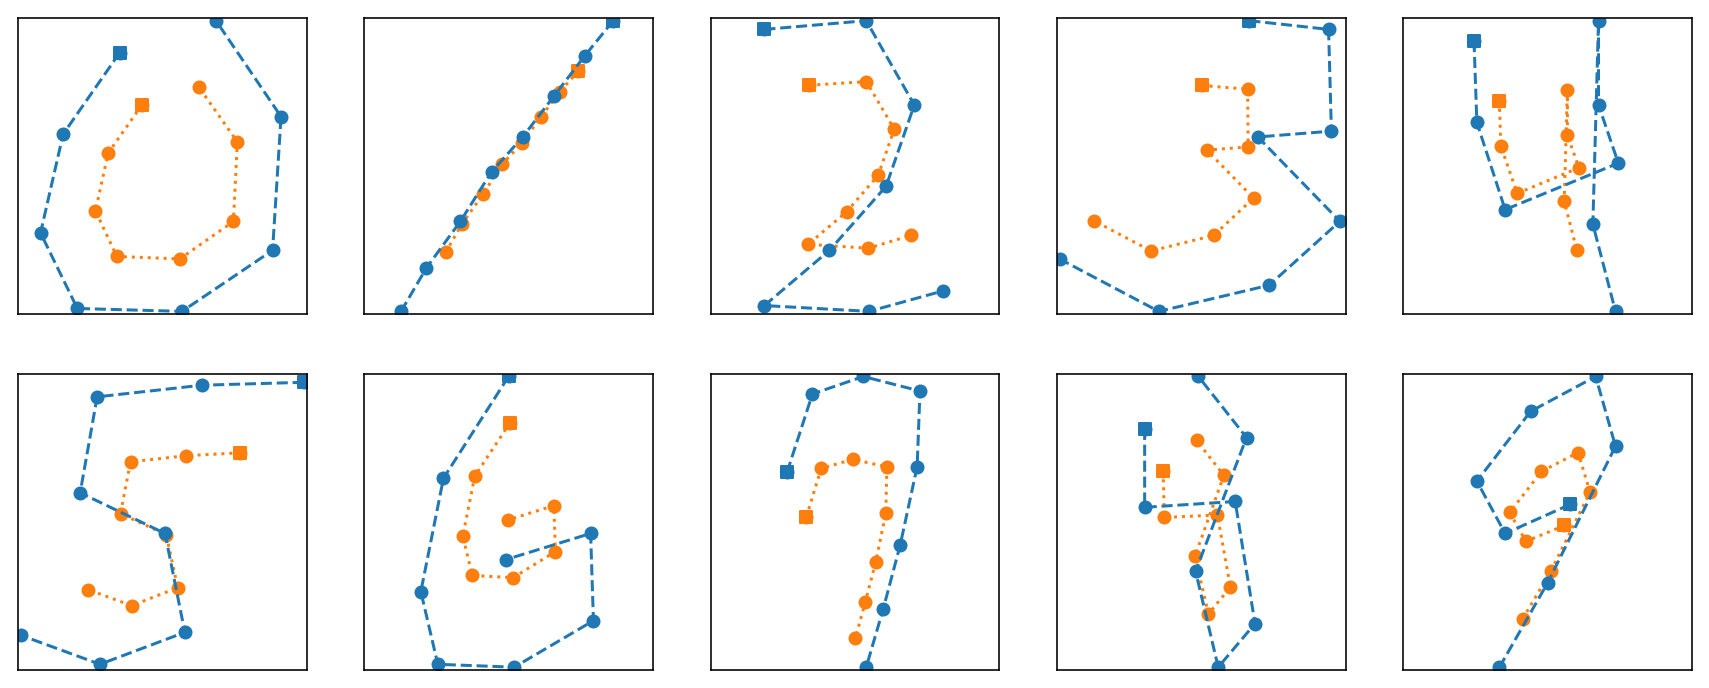

In [32]:
np.random.seed(2)
r, c = 2, 5
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    plt.imshow(img, cmap='gray')
    plt.title(str(allmnist_l[indx]))
    plt.xticks([])
    plt.yticks([])
plt.show()
np.random.seed(2)
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], return_clusters=True)
    plot_coord(xys,'.')
    plt.xticks([])
    plt.yticks([])
plt.show()
np.random.seed(2)
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], return_clusters=True)
    plot_clusters(kms, xys, '.')
    plt.xticks([])
    plt.yticks([])
plt.show()
np.random.seed(2)
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], return_clusters=True)
    plot_exfeatures(pts)
    plt.xticks([])
    plt.yticks([])
plt.show()
np.random.seed(2)
plt.figure(figsize=(15,6))
for i in range(r*c):
    indx = samples[i][0]
    plt.subplot(r,c,i+1)
    img = allmnist_f.iloc[indx].values.reshape((28,28))
    pts, kms, xys = feature_extractor(allmnist_f.iloc[indx].values, allmnist_l[indx], return_clusters=True)
    plot_exfeatures(pts, ':o', c='tab:orange')
    plot_exfeatures(scale(pts))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [33]:
mnist_pendigits = pd.DataFrame(columns=['x1','y1','x2','y2','x3','y3','x4','y4','x5','y5','x6','y6','x7','y7','x8','y8'],dtype='int64')
np.random.seed(17)
for i in range(len(features)):
    pts, kms, xys = feature_extractor(features.iloc[i].values, label[i], return_clusters=True)
    mnist_pendigits.loc[i]=scale(pts).reshape(-1)
    if i%50==0:
        print(i)
mnist_pendigits.head()

0
50
100
150
200
250
300
350
400
450


,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8
0,49,84,27,58,10,30,19,0,56,0,81,25,89,60,79,100
1,35,87,13,57,8,20,28,0,61,11,85,39,91,76,66,100
2,60,88,29,64,6,33,14,0,50,4,82,24,92,60,93,100
3,42,85,22,57,11,26,28,0,64,6,85,34,88,70,70,100
4,25,100,14,64,6,32,22,0,65,0,93,29,86,67,61,94


In [34]:
mnist_pendigits.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8
0,49,84,27,58,10,30,19,0,56,0,81,25,89,60,79,100
1,35,87,13,57,8,20,28,0,61,11,85,39,91,76,66,100
2,60,88,29,64,6,33,14,0,50,4,82,24,92,60,93,100
3,42,85,22,57,11,26,28,0,64,6,85,34,88,70,70,100
4,25,100,14,64,6,32,22,0,65,0,93,29,86,67,61,94


In [35]:
mnist_pendigits['label']=label

In [36]:
mnist_pendigits.to_csv('data/mnist_to_pendigits.csv',index=False)

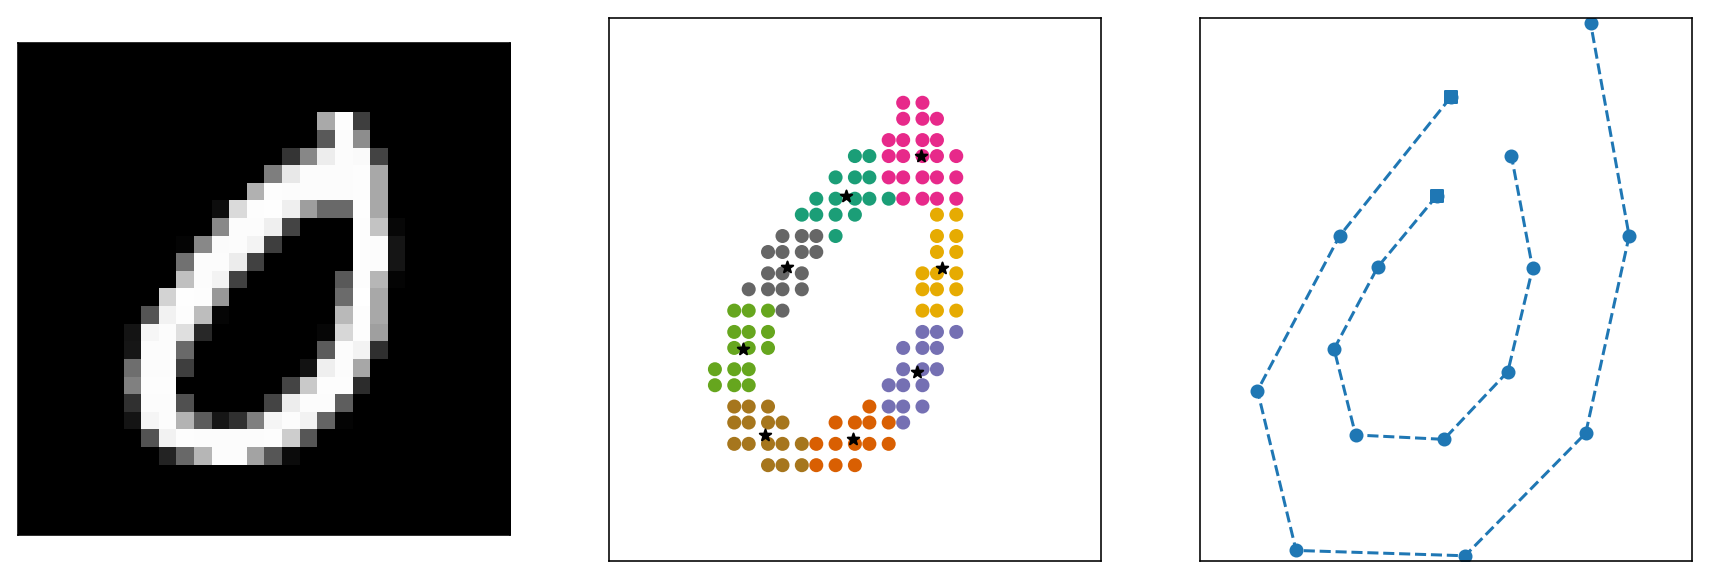

In [37]:
indx=0
np.random.seed(0)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plot_mnist(features.iloc[indx].values)
pts, kms, xys = feature_extractor(features.iloc[indx].values, label[indx], return_clusters=True)
plt.subplot(1,3,2)
plot_clusters(kms, xys)
plt.subplot(1,3,3)
plot_exfeatures(pts)
plot_exfeatures(scale(pts))
plt.show()

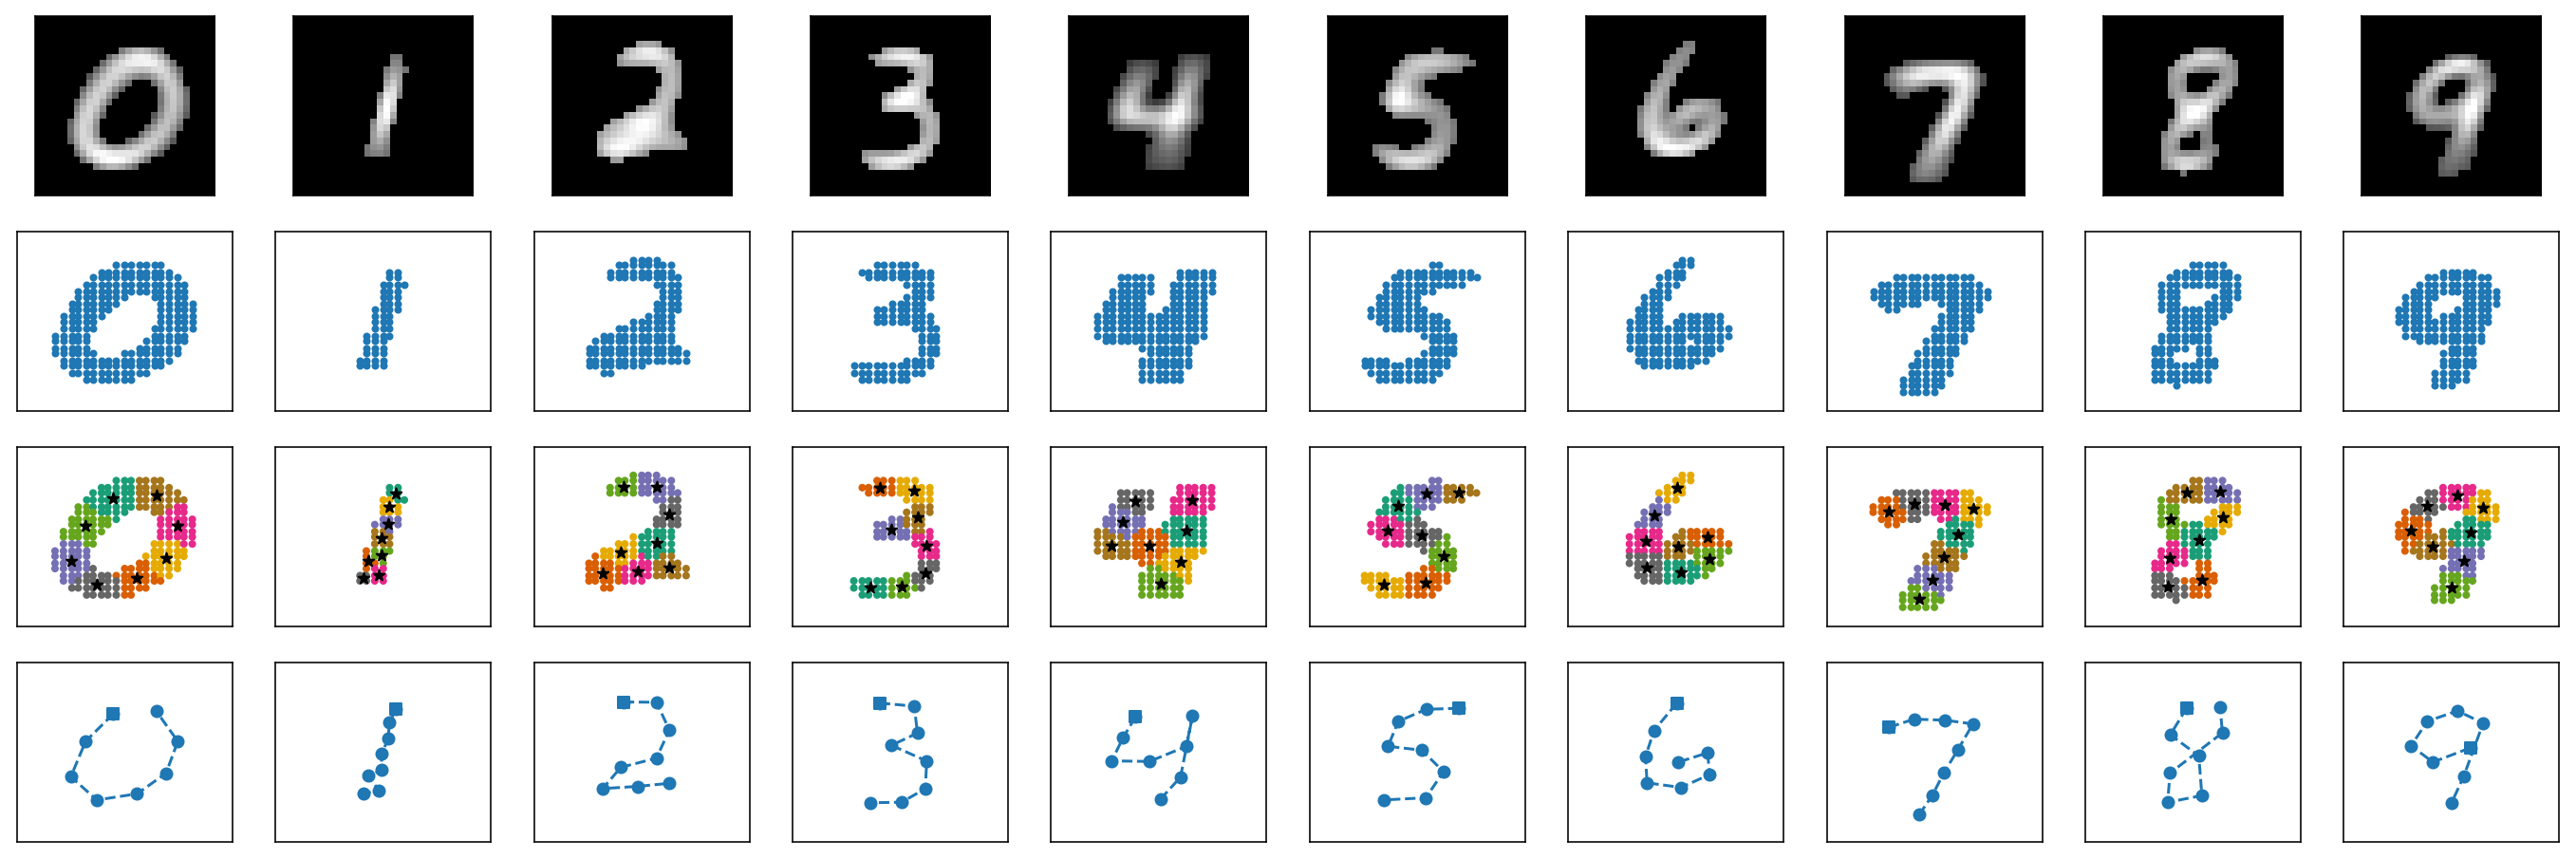

In [38]:
np.random.seed(2)

plt.figure(figsize=(24,8))
for j in range(10):
    img= average_mnist[j]
    img[img<thld[j]] = 0
    plt.subplot2grid((4,10),(0, j))
    plot_mnist(img)
    kms,xys = mnist2clusters(img, pixval_min=thld[j])
    plt.subplot2grid((4,10),(1, j))
    plot_coord(xys,'.')
    plt.subplot2grid((4,10),(2, j))
    plot_clusters(kms, xys,'.')
    tmplt = centroids[j][order[j]]
    plt.subplot2grid((4,10),(3, j))
    plot_exfeatures(tmplt)